# DSC550 
- **Name**: Rio Atmadja
- **Date**: September 22, 2020 
- **Description**: Exercise 4.2 (Build Your Text Classifier) 

# Assignments
    1. Load the data file DailyComments.csv from the Week 4 Data Files into a data frame.
    2. Identify a scheme to categorize each comment as positive or negative. You can devise your own scheme or find a commonly used scheme to perform this sentiment analysis. However you decide to do this, make sure to explain the scheme you decide to use.
    3. Implement your sentiment analysis with code and display the results. Note: DailyComments.csv is a purposely small file, so you will be able to clearly see why the results are what they are.
    4. For up to 5% extra credit, find another set of comments, e.g., some tweets, and perform the same sentiment analysis.


In [1]:
%%capture
import pandas as pd
import numpy as np
import re 
import os 
import json 

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score 
from textblob import TextBlob
from urllib import request 
from scipy.sparse.csr import csr_matrix 

# Alias 
from typing import Dict, List 
from pandas.core.frame import DataFrame 
from pandas.core.series import Series

# Exceptions
from pandas.errors import EmptyDataError
from urllib.error import HTTPError
from http.client import HTTPResponse

import matplotlib.pyplot as plt 
np.random.seed(10000)

### GET Request

In [2]:
def curl(url: str) -> HTTPResponse:
    """
    |Description
    |-----------
    | Helper function to create a GET request
    |Parameters
    |-----------
    |:url: given a valid url 
    |:return: an HTTPResponse object
    """
    headers: Dict = {'User-Agent': 'DSC550-Week4 Assignment', 
                     'Accept': "image/avif,image/webp,image/apng,image/*,*/*;q=0.8" 
                    }
    try:
        return request.urlopen(request.Request(url, headers=headers))
        
    except HTTPError as e:
        raise HTTPError(f"Unable to connect to the {url}") from e

### Label Prediction 

In [3]:
def label_prediction(comment: str, sentiment: object) -> Dict: 
    """
    |Description
    |-----------
    |Helper function to label predictions based on instantiated SentimentAnalysis object
    | 
    |Parameters
    |----------
    |:comment: given the comment to be label
    |:sentiment: given an instantiated SentimentAnalysis object
    |:return: a sentiment label (Positive or Negative) 
    """
    sentiment.predict_text(text=comment) # make prediction based on the trained corpus 
    positve, negative = tuple(sentiment.probability_.values())
    return { 'Label': sentiment.get_labels().get('Label'),
             'Positive Probability': positve, 
             'Negative Probability': negative
           }

### Sentiment Analysis Implementation 

In [4]:
class SentimentAnalysis(object):
    """
    class SentimentAnalysis(object)
            SentimentAnalysis(text: str, ngrams: tuple, stop_words: str = 'english',  **kwargs)
    
    Function Description
    -----------
    This is an implementation of Sentiment Analysis class for DSC550 (Bellevue University) Week-4 Assignment. This class has the following methods:  
    
    Private Functions 
    -----------------
    - __load_corpus__: this function will download and parse the corpus from github
    - __load_classifier__: load the given classifier from the pickle file
    - __load_file__: this function will load the given pickle file 
    - __save_classifiers__: save the classifier to local pickle file
    - __predict__: predict the given text based on the trained corpus
    
    Public Functions
    ----------------
    - to_csv: parse the string comma separated representation 
    - predict_text: call the private function __predict__
    - fit: fit the corpus 
    - get_labels: label the given text as positive or negative 
    - get_accuracy: get the accuracy of the classifier
    - get_model_eval: get the score of the cross-validation from the given scoring method
    - to_csv: function to convert unstructured text into a comma separated form
    - get_roc_auc: calcluate the Receiver Operating Curve AUC

    Parameters
    ----------
    - texts: given a string of text 
    - ngrams: optional parameters with default value (1,3)
    - stop_words: optional parameters with default value english
    - kwargs: for now clf and evaluate_model are supported (i.e. {clf: MultiNomialNB(), evaluate_model: True})
        - clf_name: given the classifier name
        - clf: given the Scikit-Learn Classifier Object
        - evaluate_model: If set to True, then it will compute the accuracy using cross validations
        - scoring: given the scoring methods
        - save_clf: pickle the classifiers 

    Examples
    --------
    >>> sentiment_analysis = SentimentAnalysis(texts=["There' s nothing special happening today."], **{'clf': logreg} )
    >>> sentiment_analysis.fit() 
    >>> sentiment_analysis.get_labels() 
    >>> {'Text': ["There' s nothing special happening today."], 'Label': 'Positive'}
    """
    
    def __init__(self, texts: List, ngrams: tuple = (1,3), stop_words: str = 'english', **kwargs):
        self.texts:str = texts
        self.ngrams: tuple = ngrams
        self.stop_words: str = stop_words
        self.parameters: Dict = kwargs

        # Local variable
        self.labels_ : Dict = {}
        self.probability_ : Dict = {} 
        self.corpus: DataFrame = pd.DataFrame() 
        self.corpus_link: str = "https://raw.githubusercontent.com/ratmadjads/DSC550/master/datasets/googleplaystore_user_reviews.csv"
        self.clf = None 
        self.y_pred_class = None
        self.y_pred_proba = None 
        self.y_true = None 
        self.accuracy: float = 0.0
        self.roc_auc_score: float = 0.0
        self.clf_pickle_path: str = "./clf_df.pickle"
        self.model_eval: float = 0.0 
        self.clf_name: str = self.parameters.get('clf_name', 'Logistic Regression') # Default is Logistic Regression
        self.file_name: str = re.sub(' ', '_', self.clf_name)
        self.tfidf_transform_path: str = "tfidf_transform.pickle"
        self.word_vector_path: str = "word_vect.pickle"
        self.train_dataset_path : str = "training.pickle"
        self.test_dataset_path : str = "testing.pickle"
        self.train_dtm_path: str = "trained_dtm.pickle" # path to the trained document-term matrix 
        self.test_dtm_path: str = "test_dtm.pickle"
        
        if not self.texts and not isinstance(texts, List):
            raise ValueError(f"ERROR: you must provide parameter texts")  
            
    def to_csv(self, text: str) -> object: 
        """
        |Descriptions 
        |-------------
        |Helper function to parse string comma separated representation
        |
        |Parameters
        |----------
        |:text: given a non empty comma separated representation text
        |:return: an object such as list with comma separte attributes or np.nan if the review field is empty
        """

        if not isinstance(text, str): 
            raise TypeError(f"ERROR: {text} must be str not type of {type(text)}")

        # replace with np.nan if there is no review from the corpus  
        if not '\"' in text:
            return np.nan 

        else: 

            # Get the first and last index of double quotes 
            first_index: int = text.index("\"")
            last_index: int = text.rindex("\"")

            if first_index and last_index: 
                review = text[first_index:last_index]
                row = text.replace(review, "").split(',')
                row[1] = review # append review
                return row[0:3] + list(filter(lambda column: re.match(r"[0-9]+\.[0-9]+" , column), row))

            return np.nan    
        
    def __load_corpus__(self) -> DataFrame:
        """
        |Description
        |-----------
        |Helper function to download sample corpus from Github and remove the Null value by the sentiment column. 
        |
        |Parameters
        |----------
        |:return: a corpus dataframe 
        """
        try:
            response = request.urlopen(request.Request(self.corpus_link, headers={'User-Agent': 'DSC550-Week4 Assignment', 
                                                                                  'Accept': "image/avif,image/webp,image/apng,image/*,*/*;q=0.8" 
                                                                                  }))
        except HTTPError as e: 
            raise HTTPError(f"ERROR: Unable to download corpus from {self.corpus_link}") from e 
            
        raw_data: List[str] = response.read().decode('utf-8').split('\r\n')
        corpus_df: DataFrame = pd.DataFrame( pd.DataFrame( raw_data[1:], columns=['Texts'])['Texts'].astype(str).apply(self.to_csv).dropna().tolist(), columns=raw_data[0].split(','))
        corpus_df = corpus_df.dropna(subset=['Sentiment'])
        corpus_df = corpus_df.query("Sentiment != 'Neutral'") # Select positive and negative comments 
        corpus_df['Translated_Review'] = corpus_df['Translated_Review'].astype(str)
        self.corpus = corpus_df
        
        return self.corpus
    
    def __load_classifier__(self) -> DataFrame:
        """
        |Description
        |-----------
        |Helper function to load pickle file from local directory
        |
        |Parameters
        |----------
        |:return: an empty dataframe with default column Classifier_Name and Classifier or dataframe that contains trained classifiers
        """
        if not os.path.exists(self.clf_pickle_path):
            return pd.DataFrame(columns=['Classifier_Name', 'Classifier']) # return empty dataframe 
        
        clf_df: DataFrame = pd.read_pickle(self.clf_pickle_path)
        return clf_df
    
    def __save_classifiers__(self) -> bool:
        """
        |Description
        |-----------
        |Helper function to save classifiers to the local directory 
        |
        |Parameters
        |----------
        |:return: a boolean value, if it is successful then return True, otherwise False 
        """
        clf_df: DataFrame = self.__load_classifier__()
        if clf_df['Classifier_Name'].str.count(self.clf_name).sum() ==  0:  # append if the classifier does not exists in the pickle file 
            clf_df = clf_df.append([{'Classifier_Name': self.clf_name, 'Classifier': self.clf}], ignore_index=True)
            clf_df.index = np.arange(1, clf_df.shape[0] + 1 ) 
            
        clf_df.to_pickle(f"{self.clf_pickle_path}")
        return clf_df.shape[0] > 0 and os.path.exists(self.clf_pickle_path)
    
    def __save_obj__(self, *args):
        """
        |Description
        |------------
        |Helper function to save training and testing dataset, as well as the document-term matricies 
        |
        |Parameters
        |----------
        |:kwargs: given an optional argumens 
        |:return:
        """
        transform_tfidf, word_vect, training, testing, train_df, test_df = args
        
        pd.DataFrame({'TFIDF':transform_tfidf}, index=[1]).to_pickle(f"./{self.file_name}_{self.tfidf_transform_path}") 
        pd.DataFrame({'Word_Vect': word_vect} , index=[1]).to_pickle(f"./{self.file_name}_{self.word_vector_path}") 
        pd.DataFrame({'Train_DTM': training }, index=[1]).to_pickle(f"./{self.file_name}_{self.train_dtm_path}")
        pd.DataFrame({'Test_DTM': testing }, index=[1]).to_pickle(f"./{self.file_name}_{self.test_dtm_path}")
        train_df.to_pickle(f"./{self.file_name}_{self.train_dataset_path}") 
        test_df.to_pickle(f"./{self.file_name}_{self.test_dataset_path}") 
        
    def __load__file__(self, file_path: str, column_name: str = "") -> object: 
        """
        |Description
        |-----------        
        |Generic function to load all pickle files and return accordingly
        |
        |Parameters
        |----------
        |:file_path: given a valid file path
        |:column_name: given column name to be pickle
        |:return: an object 
        """
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"ERROR: Unable to load file {file_path} because it is missing")

        return pd.read_pickle(file_path)[column_name].iloc[0] if column_name else pd.read_pickle(file_path)
    
    def predict_text(self, text: str):
        """
        |Description
        |-----------        
        |Helper function to be called by the client program
        |
        |Parameters
        |----------
        |text: given non empty text
        |:return: None
        """
        if not text:
            raise ValueError("Text cannot be emtpy.")
            
        self.__predict__(text=text)
        
    def __predict__(self, transform_tfidf: object = None , word_vect: object = None, text: str = ""):
        """
        |Description
        |-----------
        |This function will predict the given text or comment as positive or negative based on the training corpus 
        |
        |Parameters
        |----------
        |:transform_tfidf: an optional parameter for transform_tfidf 
        |:word_vect: an optional parameter for word_vect
        |:text: an optional parameter for non empty text
        |:return: None
        """
        if not self.clf:
            raise ValueError(f"Must call the fit function before making prediction")
        
        if not transform_tfidf and not word_vect:
            transform_tfidf = self.__load__file__(file_path=f"./{self.file_name}_{self.tfidf_transform_path}", column_name='TFIDF')
            word_vect = self.__load__file__(file_path=f"./{self.file_name}_{self.word_vector_path}", column_name='Word_Vect')

        negative, positive = tuple(self.clf.predict_proba(transform_tfidf.transform(word_vect.transform( [text] if text else self.texts)))[0])
        self.labels_ = {'Text': text if text else self.texts,
               'Label': 'Positive' if negative < positive and positive > 0.7 else 'Negative'}
        self. probability_ = {'Positive': positive,
                              'Negative': negative}
        
        return None 
    
    def fit(self) -> bool:
        """
        |Description
        |-----------
        |Classify the text based on the corpus, the default classifier is Logistic Regression unless it is provided by the kwargs 
        |Note: The corpus is trained on Google Play Store Reviews dataset
        |Parameters
        |----------
        |:return: a boolean True if it is successful otherwise return False
        """
        
        # Load the classifier and predict the given text or comment, if the classifier exists in the pickle file
        clf_df: DataFrame = self.__load_classifier__()
        if not clf_df.empty and clf_df['Classifier_Name'].str.count(self.clf_name).sum() > 0:
            self.clf = clf_df.query(f"Classifier_Name == '{self.clf_name}' ").iloc[0][-1] # get specific classifier 
            self.__predict__()
            return self.clf != None
        
        corpus: DataFrame = self.__load_corpus__() # Load Google Play Store Reviews           
        if corpus.empty: 
            raise EmptyDataError("Something went wrong, corpus should not be empty. Please re-run again")
        
        response_vector = corpus.Sentiment.map(dict(zip(list(corpus.Sentiment.unique()),[1,0]))) # Label Positive comments as 1 and Negative comments as 0
        corpus['response_vector'] = response_vector
        
        # Split to training and testing data 
        train_df, test_df = train_test_split( corpus[['Translated_Review','response_vector']], random_state=np.random.randint(100,200), test_size=0.2)
        
        # create a collection of a matrix of token counts and transform the count matrix to a normalized tf-idf representation
        word_vect = CountVectorizer(ngram_range=self.ngrams, stop_words=self.stop_words) 
        word_counts = word_vect.fit_transform(train_df['Translated_Review'])
        transform_tfidf = TfidfTransformer() 
        training = transform_tfidf.fit_transform(word_counts)
        word_counts_vector = word_vect.transform(test_df['Translated_Review'])
        testing = transform_tfidf.transform(word_counts_vector)

        # train Google Play Store Reviews 
        self.clf =  self.parameters.get('clf') if self.parameters.get('clf',None) else LogisticRegression(C=1e35)
        self.clf.fit(training, train_df['response_vector'])
        self.y_pred_class = self.clf.predict(testing)
        self.y_pred_proba = self.clf.predict_proba(testing)[:,1]
        
        # If kwargs evaluate_model is provided use cross-validation instead 
        if self.parameters.get('evaluate_model'):
            try: 
                self.model_eval = cross_val_score(self.clf, training, train_df['response_vector'], scoring= self.parameters.get('scoring') if self.parameters.get('scoring') else 'accuracy', cv=10).mean() 
                return self.model_eval
            
            except ValueError as e: 
                scoring_methods: List[str] = metrics.SCORERS.keys() 
                raise ValueError(f"ERROR: Use the following scoring methods {scoring_methods}") from e 
        
        self.__predict__(transform_tfidf=transform_tfidf, word_vect=word_vect)        
        self.accuracy = metrics.accuracy_score(y_true=test_df['response_vector'], y_pred=self.y_pred_class)
        self.roc_auc_score = metrics.roc_auc_score(y_true=test_df['response_vector'], y_score=self.y_pred_proba)
        self.y_true = test_df['response_vector']
        
        # If kwargs save_clf is provided saved the trainined classifier into pickle file
        if self.parameters.get('save_clf'):              
            # Save the initial classifier for quicker access 
            if clf_df.empty:
                save_classifiers: bool = self.__save_classifiers__() 
                if not save_classifiers:
                    raise ValueError(f"Unable to pickle the given {self.clf_name} classifier")
            
                # initially save word_vect and tfidf_tranform 
                self.__save_obj__(*(transform_tfidf, word_vect, training, testing, train_df, test_df))
                 
            # Load, Lookup, and append 
            else:
                if self.clf_name == 'Logistic Regression':
                    raise ValueError(f"{self.clf_name} is the default classifier, please provide different classifier.")
                
                save_classifiers: bool = self.__save_classifiers__()
                self.__save_obj__(*(transform_tfidf, word_vect, training, testing, train_df, test_df))
                if not save_classifiers:
                    raise ValueError(f"Unable to pickle the given {self.clf_name} classifier")
        
        return self.clf != None # if the self.clf has not been instantiated it will return false 
    
    def get_labels(self) -> Dict: 
        """
        |Description
        |-----------
        |Helper function to return labeled text as positive or negative 
        |
        |Parameters
        |----------
        |:return: a dictionary with labeled text 
        """
        if not self.labels_: 
            raise ValueError("ERROR: Please call the fit function or re-run without evaluate_model = False.")
        
        return self.labels_ 
    
    def get_accuracy(self) -> float:
        """
        |Description
        |-----------
        |Helper function to return the accuracy of the given classifier 
        |
        |Parameters
        |-----------
        |:return: the accuracy score in float
        """
        if not self.accuracy: 
            if os.path.exists(f"./{self.file_name}_{self.train_dataset_path}") and os.path.exists(f"./{self.file_name}_{self.test_dataset_path}") and os.path.exists(f"./{self.file_name}_{self.test_dtm_path}"):
                test_df: DataFrame = self.__load__file__(file_path=f"./{self.file_name}_{self.test_dataset_path}") 
                testing: csr_matrix = self.__load__file__(file_path=f"./{self.file_name}_{self.test_dtm_path}")['Test_DTM'].iloc[0]
                self.y_pred_class = self.clf.predict(testing)
                return metrics.accuracy_score(y_true=test_df['response_vector'], y_pred=self.y_pred_class) 
            
            raise ValueError("ERROR: Please call the fit function or re-run without evaluate_model = False.")
            
        return self.accuracy
    
    def get_roc_auc(self) -> float: 
        """
        |Description
        |-----------
        |Helper function to calculate the area under the curve
        |
        |Parameters
        |----------
        |:return: area under the curve score
        """
        if not self.roc_auc_score:
            if os.path.exists(f"./{self.file_name}_{self.train_dataset_path}") and os.path.exists(f"./{self.file_name}_{self.test_dataset_path}") and os.path.exists(f"./{self.file_name}_{self.test_dtm_path}"):
                test_df: DataFrame = self.__load__file__(file_path=f"./{self.file_name}_{self.test_dataset_path}") 
                testing: csr_matrix = self.__load__file__(file_path=f"./{self.file_name}_{self.test_dtm_path}")['Test_DTM'].iloc[0]
                self.y_true = test_df['response_vector']
                self.y_pred_proba = self.clf.predict_proba(testing)[:,1]
                return metrics.roc_auc_score(y_true=test_df['response_vector'],y_score=self.y_pred_proba)
            
        return self.roc_auc_score
    
    def get_model_eval(self, scoring: str = "") -> float:
        """
        |Description
        |-----------
        | Helper function to return the score based on the scoring method (e.g. accuracy, roc_auc)
        |
        | Parameters 
        |-----------
        |:scoring: given a valid scoring methods
        |:return: model evaluation score 
        """
        if not self.model_eval: 
            feature_matrix_path: str = f"{self.file_name}_{self.train_dtm_path}"
            response_vector_path: str = f"{self.file_name}_{self.train_dataset_path}"
            
            training: csr_matrix = self.__load__file__(file_path=feature_matrix_path)['Train_DTM'].iloc[0]
            train_df: DataFrame = self.__load__file__(file_path=response_vector_path)
            if os.path.exists(feature_matrix_path) and os.path.exists(response_vector_path):

                return cross_val_score(self.clf, training, train_df['response_vector'], scoring=self.parameters.get('scoring') if self.parameters.get('scoring') else scoring, cv=10).mean()

            raise ValueError("ERROR: Please call the fit function or re-run without evaluate_model = False.")
        
        return self.model_eval

### Sentiment Analysis Documentation

# Load dataset

In [5]:
COMMENTS_PATH: str = "./DailyComments.csv"
if not os.path.exists(COMMENTS_PATH):
    raise FileNotFoundError(f"Unable to find {COMMENTS_PATH}, make sure it is the right path.")
    
comments: DataFrame = pd.read_csv(COMMENTS_PATH)

# Categorize Daily Comments using `Text Blob` and Calculate Sentiment polarity 
- **I'm labeling all the comments as negative if the sentiment polarity is below zero, otherwise it is labeled as positive comments.**

In [6]:
comments['Sentiment Polarity'] = comments.comments.apply(lambda comment: TextBlob(comment).sentiment.polarity)
comments['Label'] = np.where(comments['Sentiment Polarity'] >= 0, 'Good', 'Bad')
comments

,Day of Week,comments,Sentiment Polarity,Label
0,Monday,"Hello, how are you?",0.000000,Good
1,Tuesday,Today is a good day!,0.875000,Good
2,Wednesday,It's my birthday so it's a really special day!,0.446429,Good
3,Thursday,Today is neither a good day or a bad day!,-0.087500,Bad
4,Friday,I'm having a bad day.,-0.700000,Bad
5,Saturday,There' s nothing special happening today.,0.357143,Good
6,Sunday,Today is a SUPER good day!,0.604167,Good


# Testing Sentiment Analsis Implementation
- **Classify comments based on trained corpus**
- **Note**: Because the save_clf parameter is set to True, then the classifier models will be pickled. The trained models, then used to predict the new set of comments. Also if the pickle classifiers has already been generated, the classification process should be quicker. 

In [7]:
%%capture
# approximately 1 min to train and save classifier models.
results: List = []
comment:str = comments.comments.iloc[5]
for clf_name, clf in { 'Logistic Regression': LogisticRegression(C=1e25), 'Multinomial NB': MultinomialNB(), 'Bernouli NB': BernoulliNB() }.items(): 
    sentiment_analysis = SentimentAnalysis(texts=[comment],  **{'clf': clf, 'clf_name': clf_name , 'save_clf': True } )
    sentiment_analysis.fit() 
    results.append({**sentiment_analysis.get_labels(), **{ "Classifier": clf_name, "Accuracy": sentiment_analysis.get_accuracy()}})

In [8]:
pd.DataFrame(results,index=range(1,4))

,Text,Label,Classifier,Accuracy
1,[There' s nothing special happening today.],Positive,Logistic Regression,0.911130
2,[There' s nothing special happening today.],Positive,Multinomial NB,0.760051
3,[There' s nothing special happening today.],Positive,Bernouli NB,0.779518


- **Model evaluations with cross validations**

In [9]:
model_evals: List = []
comment: str = comments.comments.iloc[1]
model_evaluations: Dict = {}
for clf_name, clf in { 'Logistic Regression': LogisticRegression(C=1e25), 'Multinomial NB': MultinomialNB(), 'Bernouli NB': BernoulliNB()}.items(): 
    sentiment_analysis = SentimentAnalysis(texts=[comment], **{ 'clf': clf, 'clf_name': clf_name , 'save_clf': True ,'evaluate_model':True, 'scoring': 'accuracy' } )
    sentiment_analysis.fit() 
    model_evals.append( { 'Classifier': clf_name, 'Accuracy' : sentiment_analysis.get_model_eval() , 'ROC AUC': sentiment_analysis.get_roc_auc()}) 
    model_evaluations[clf_name] = (sentiment_analysis.y_pred_proba, sentiment_analysis.y_true )

In [10]:
pd.DataFrame(model_evals,index=range(1,4)) 

,Classifier,Accuracy,ROC AUC
1,Logistic Regression,0.902095,0.952238
2,Multinomial NB,0.758363,0.873825
3,Bernouli NB,0.762172,0.669711


- **Performance Graphs**

I'm using area under the curve to evaluate, which classifier model is better on average and to see the trade off between the True Positive and False Positive rates of a classifier. The rank of the best model:
1. **Logistic Regression** has an accuracy of **90.20%** and the AUC score of **0.9569**
2. **Multinomial Naive Bayes** has an accuracy of **75.84%** and the AUC score of **0.8749**
3. **Bernouli Naive Bayes** has an accuracy of **76.22%** and the AUC score of **0.6700**

Also, if the model is simply performing random guessing (i.e. a record is classified as positive, irrespective of its attribute set.) the score of the AUC would equal 0.5 and the graph should reside along `red diagonal line`. Overall, the 3 classifiers performs above the average.

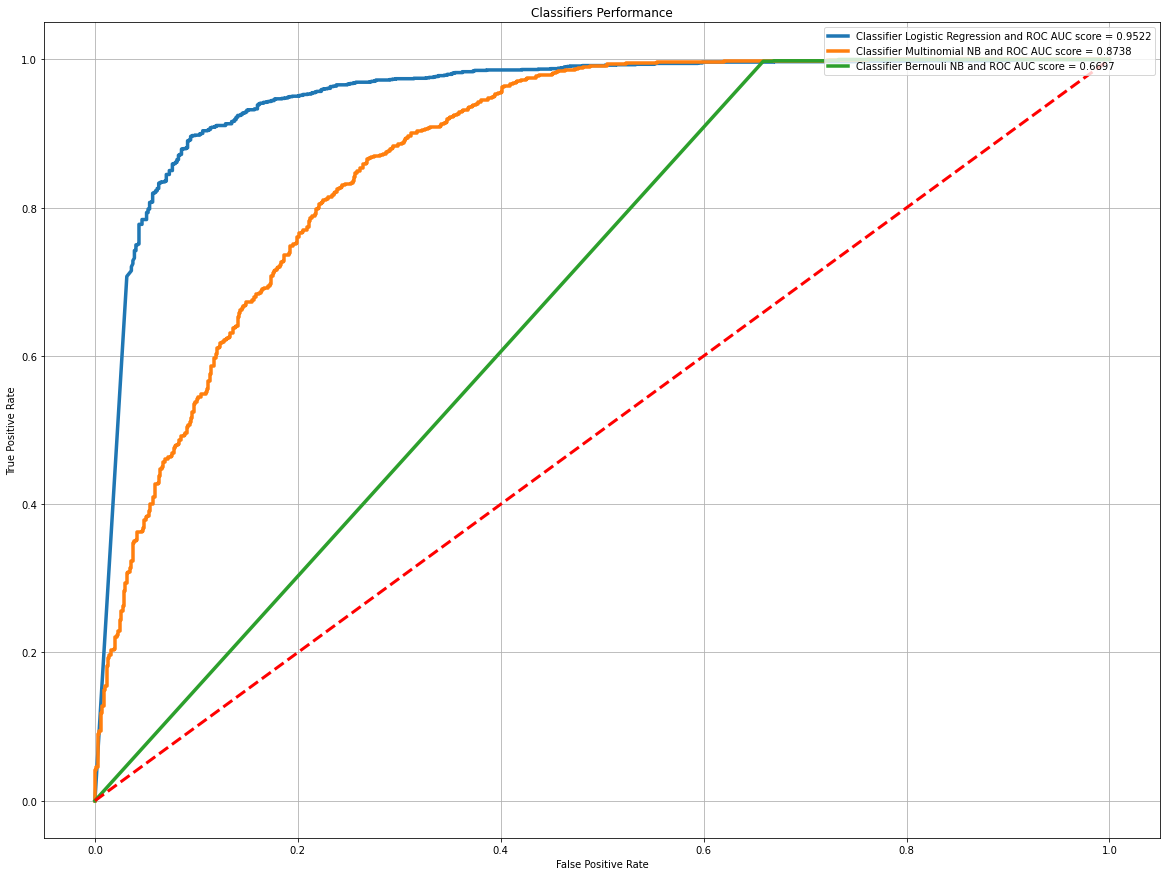

In [11]:
plt.rcParams['figure.figsize'] = (20,15)
current_index: int = 0 # pointer to the current index
for clf_name, data in model_evaluations.items():
    y_pred_proba, y_true = list(data)
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_true, y_score=y_pred_proba)
    plt.plot(fpr,tpr, label=f"Classifier {clf_name} and ROC AUC score = {model_evals[current_index].get('ROC AUC'):.4f}", linewidth=3.5)
    current_index += 1 
plt.title("Classifiers Performance")
plt.grid(True)
plt.plot(np.linspace(0,1), np.linspace(0,1),color='red', linewidth=3.0, linestyle='--') # draw red diagonal line connecting (TPR=0, FPR=0, and TPR=1, and FPR=1)
plt.legend(loc='upper right') 
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show() 

- **Classifying Daily Comments with `SentimentAnalysis Class`**

In [12]:
%%capture
sentiment = SentimentAnalysis(texts=[comments.comments.iloc[0]])
sentiment.fit() 

In [13]:
pd.concat( [ comments, pd.DataFrame( comments.comments.apply(label_prediction, args=(sentiment,)).tolist()  ) ] , axis=1) 

,Day of Week,comments,Sentiment Polarity,Label,Label,Positive Probability,Negative Probability
0,Monday,"Hello, how are you?",0.000000,Good,Negative,1.784128e-06,0.999998
1,Tuesday,Today is a good day!,0.875000,Good,Positive,1.000000e+00,0.000000
2,Wednesday,It's my birthday so it's a really special day!,0.446429,Good,Positive,1.000000e+00,0.000000
3,Thursday,Today is neither a good day or a bad day!,-0.087500,Bad,Positive,9.999041e-01,0.000096
4,Friday,I'm having a bad day.,-0.700000,Bad,Negative,1.025530e-41,1.000000
5,Saturday,There' s nothing special happening today.,0.357143,Good,Positive,9.992730e-01,0.000727
6,Sunday,Today is a SUPER good day!,0.604167,Good,Positive,1.000000e+00,0.000000


# Extra Credit: Sentiment Analysis on `Controversial Comments` from Week 2 
- **Note**: Pick only 10 random comments from controversial comments from week 2

In [14]:
controversial_comments: DataFrame = pd.read_pickle('https://raw.githubusercontent.com/ratmadjads/DSC550/master/datasets/comments.pickle')
random_index: List[int] = controversial_comments.index.tolist()
np.random.shuffle(random_index)
controversial_comments.index = controversial_comments.loc[random_index].index

In [15]:
%%capture
# Load Logistic Regression pickle and use it for predicting labels
sentiment = SentimentAnalysis(texts=[comment], **{'clf': LogisticRegression(C=1e25), 'clf_name':  'Logistic Regression' , 'save_clf': True})
sentiment.fit() 

In [16]:
pd.concat([ pd.DataFrame( { 'Text' :controversial_comments.Text.iloc[0:10].tolist() } ), 
           pd.DataFrame( controversial_comments.Text.astype(str).iloc[0:10].apply(label_prediction, args=(sentiment, )).tolist() )], axis=1)

,Text,Label,Positive Probability,Negative Probability
0,Start a non-profit business selling Confederat...,Positive,9.999885e-01,1.152232e-05
1,It's like someone purposely digs for specific ...,Negative,6.563734e-01,3.436266e-01
2,The only proof you are ever going to be able t...,Positive,9.997918e-01,2.082175e-04
3,The Clinton campaign was convinced they were g...,Positive,1.000000e+00,3.298251e-12
4,CNN has been literally lying through their tee...,Negative,1.464116e-09,1.000000e+00
5,Go Arab Spring on his ass.,Positive,8.661109e-01,1.338891e-01
6,Those are projected electoral votes. It could ...,Positive,9.874265e-01,1.257349e-02
7,"if someone starts a sentence with\n\n&gt; ""You...",Positive,1.000000e+00,6.439294e-15
8,Lindsey Graham is a good guy tho,Positive,1.000000e+00,0.000000e+00
9,Makes sense. He's incompetent.,Positive,8.773505e-01,1.226495e-01


# Extra Credit: <a src='https://www.kaggle.com/bittlingmayer/amazonreviews'>Amazon Reviews <a/>
- **Note**: This dataset contains __label__1 corresponds to 1- and 2-star reviews, and __label__2 corresponds to 4- and 5-star reviews, also it originally has 400000 rows but I'm going to use about 1000 or so.

In [17]:
# Delete label and predict using Sentiment Analysis class 
amazon_reviews: str = curl(url='https://raw.githubusercontent.com/ratmadjads/DSC530/master/amazon_comments.txt').read().decode('utf-8').split("\n")[0:1000]
amz_reviews: DataFrame = pd.DataFrame(amazon_reviews, columns=['Original Reviews'])
amz_reviews['Cleaned Reviews'] = amz_reviews.apply(lambda review: re.sub("__label__[1-5].*.:" , "", review['Original Reviews'] ).lstrip() , axis=1)
amz_reviews['Original Label'] = amz_reviews['Original Reviews'].apply(lambda review: 'Negative' if '__label__1' in review  else 'Positive' )
amz_reviews.head(10)

,Original Reviews,Cleaned Reviews,Original Label
0,__label__2 Great CD: My lovely Pat has one of ...,My lovely Pat has one of the GREAT voices of h...,Positive
1,__label__2 One of the best game music soundtra...,Despite the fact that I have only played a sma...,Positive
2,__label__1 Batteries died within a year ...: I...,I bought this charger in Jul 2003 and it worke...,Negative
3,"__label__2 works fine, but Maha Energy is bett...",Check out Maha Energy's website. Their Powerex...,Positive
4,__label__2 Great for the non-audiophile: Revie...,Reviewed quite a bit of the combo players and ...,Positive
5,__label__1 DVD Player crapped out after one ye...,I also began having the incorrect disc problem...,Negative
6,__label__1 Incorrect Disc: I love the style of...,"I love the style of this, but after a couple y...",Negative
7,__label__1 DVD menu select problems: I cannot ...,I cannot scroll through a DVD menu that is set...,Negative
8,__label__2 Unique Weird Orientalia from the 19...,"Exotic tales of the Orient from the 1930's. ""D...",Positive
9,"__label__1 Not an ""ultimate guide"": Firstly,I ...","Firstly,I enjoyed the format and tone of the b...",Negative


- **Predicting Amazon Reviews using pre-trained Logisitc Regression Classifier**

In [18]:
%%time 
# It takes approximately 4 min and 52 seconds to run prediction on trained Logistic Regression Classifiers 
predicted_labels: DataFrame =  pd.DataFrame( amz_reviews['Cleaned Reviews'].apply(label_prediction, args=(sentiment, )).tolist())

CPU times: user 3min 27s, sys: 15.9 s, total: 3min 42s
Wall time: 4min 3s


In [19]:
merged_df: DataFrame = pd.concat( [ amz_reviews , predicted_labels ] ,axis=1) 
merged_df.index = np.arange(1, merged_df.shape[0]+1)
merged_df.head(10)

,Original Reviews,Cleaned Reviews,Original Label,Label,Positive Probability,Negative Probability
1,__label__2 Great CD: My lovely Pat has one of ...,My lovely Pat has one of the GREAT voices of h...,Positive,Positive,1.000000e+00,0.000000e+00
2,__label__2 One of the best game music soundtra...,Despite the fact that I have only played a sma...,Positive,Positive,1.000000e+00,0.000000e+00
3,__label__1 Batteries died within a year ...: I...,I bought this charger in Jul 2003 and it worke...,Negative,Positive,1.000000e+00,0.000000e+00
4,"__label__2 works fine, but Maha Energy is bett...",Check out Maha Energy's website. Their Powerex...,Positive,Positive,9.999749e-01,2.512662e-05
5,__label__2 Great for the non-audiophile: Revie...,Reviewed quite a bit of the combo players and ...,Positive,Positive,1.000000e+00,0.000000e+00
6,__label__1 DVD Player crapped out after one ye...,I also began having the incorrect disc problem...,Negative,Negative,1.528856e-28,1.000000e+00
7,__label__1 Incorrect Disc: I love the style of...,"I love the style of this, but after a couple y...",Negative,Positive,1.000000e+00,0.000000e+00
8,__label__1 DVD menu select problems: I cannot ...,I cannot scroll through a DVD menu that is set...,Negative,Positive,1.000000e+00,7.986944e-13
9,__label__2 Unique Weird Orientalia from the 19...,"Exotic tales of the Orient from the 1930's. ""D...",Positive,Positive,9.999966e-01,3.371413e-06
10,"__label__1 Not an ""ultimate guide"": Firstly,I ...","Firstly,I enjoyed the format and tone of the b...",Negative,Positive,1.000000e+00,0.000000e+00


- **Plot the label predictions** 

Text(0.5, 1.0, 'Predicting 1000 Amazon Reviews using Sentiment Analysis Implementation Class.')

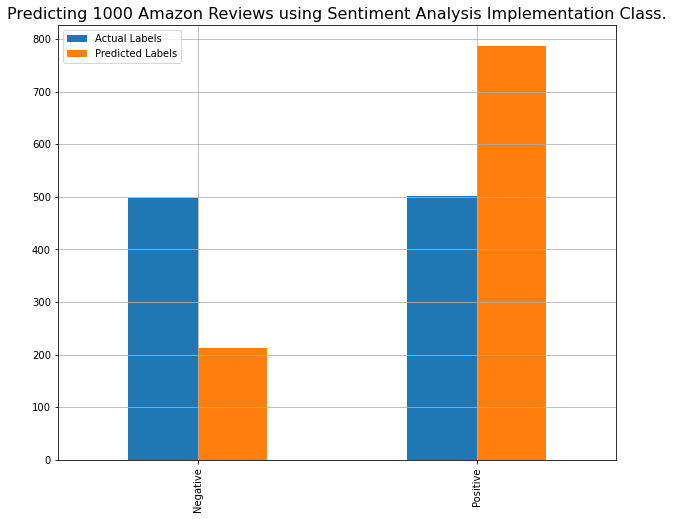

In [20]:
plt.rcParams['figure.figsize'] = (10,8)
prediction_versus_actual: DataFrame = pd.DataFrame( { 'Actual Labels' : merged_df.groupby(['Original Label']).size().to_dict() , 
               'Predicted Labels': merged_df.groupby(['Label']).size().to_dict()  } )

prediction_versus_actual.plot(kind='bar')
plt.grid(True)
plt.title("Predicting 1000 Amazon Reviews using Sentiment Analysis Implementation Class.", fontsize=16)
# Over predicted the positive comments